In [1]:
from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName("myapp1").setMaster("local")
sc = SparkContext(conf=conf)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/30 09:54:32 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/05/30 09:54:32 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/05/30 09:54:32 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/05/30 09:54:32 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


In [2]:
from pyspark.sql import SparkSession

try:
    spark = SparkSession \
        .builder \
        .appName("BigData_Project1") \
        .config("spark.some.config.option", "some-value") \
        .getOrCreate()
except:
    Pass
    

In [3]:
df = spark.read.format("csv").option("header","true").load("gs://myproject-bdpp2023-bucket1/data.csv")

In [4]:
#all imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings('ignore')
import time

from pyspark.sql.types import StringType
from pyspark.sql.functions import mean
from pyspark.sql.types import StringType
from pyspark.sql.functions import col, when, mean, sum
from pyspark.sql.functions import isnan, when, count, col
from pyspark.ml.feature import StringIndexer

from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator


In [5]:
df.head()

Row(customerID='7590-VHVEG', gender='Female', SeniorCitizen='0', Partner='Yes', Dependents='No', tenure='1', PhoneService='No', MultipleLines='No phone service', InternetService='DSL', OnlineSecurity='No', OnlineBackup='Yes', DeviceProtection='No', TechSupport='No', StreamingTV='No', StreamingMovies='No', Contract='Month-to-month', PaperlessBilling='Yes', PaymentMethod='Electronic check', MonthlyCharges='29.85', TotalCharges='29.85', Churn='No')

In [6]:
# count the number of rows in the DataFrame
num_rows = df.count()

# get the column names of the DataFrame
column_names = df.columns

print(num_rows)        # outputs the number of rows in the DataFrame
print(len(column_names))  # outputs the number of columns in the DataFrame

7043
21


In [7]:
# get the column names of the DataFrame
column_names = df.columns

print(column_names)  # outputs Index(['Name', 'Age', 'Gender'], dtype='object')


['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


In [8]:
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: string (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: string (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



In [9]:
# select the numeric columns from the DataFrame
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
numeric_df = df.select([col(c).cast("double").alias(c) for c in numeric_cols])

# compute summary statistics for the numeric columns
summary_df = numeric_df.describe()

# transpose the summary statistics DataFrame
summary_df_t = summary_df.toPandas().transpose()

print(summary_df_t)

                    0                   1                   2      3       4
summary         count                mean              stddev    min     max
tenure           7043   32.37114865824223  24.559481023094442    0.0    72.0
MonthlyCharges   7043   64.76169246059922  30.090047097678482  18.25  118.75
TotalCharges     7032  2283.3004408418697   2266.771361883145   18.8  8684.8


In [10]:
# create a new column with null values where TotalCharges cannot be casted to double
df = df.withColumn("TotalCharges_double", when(col("TotalCharges").cast("double").isNotNull(), col("TotalCharges").cast("double")))

# fill null values with the previous value using window function
from pyspark.sql.window import Window
from pyspark.sql.functions import last

window = Window.orderBy("customerID")
df = df.withColumn("TotalCharges_filled", last("TotalCharges_double", True).over(window))

# drop the original and intermediate columns
df = df.drop("TotalCharges").drop("TotalCharges_double")


In [11]:
# get the list of string columns
string_cols = [c.name for c in df.schema.fields if c.dataType == StringType()]

# loop over the string columns and apply StringIndexer
for col in string_cols:
    indexer = StringIndexer(inputCol=col, outputCol=col + "_indexed")
    df = indexer.fit(df).transform(df)
    
# drop the original string columns
df = df.drop(*string_cols)

# show the resulting DataFrame
df.show(10)

23/05/30 09:55:01 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 09:55:01 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 09:55:02 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 09:55:02 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-------------------+------------------+--------------+---------------------+---------------+------------------+--------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+----------------+------------------------+---------------------+----------------------+-------------+
|TotalCharges_filled|customerID_indexed|gender_indexed|SeniorCitizen_indexed|Partner_indexed|Dependents_indexed|tenure_indexed|PhoneService_indexed|MultipleLines_indexed|InternetService_indexed|OnlineSecurity_indexed|OnlineBackup_indexed|DeviceProtection_indexed|TechSupport_indexed|StreamingTV_indexed|StreamingMovies_indexed|Contract_indexed|PaperlessBilling_indexed|PaymentMethod_indexed|MonthlyCharges_indexed|Churn_indexed|
+-------------------+------------------+--------------+---------------------+---------------+------------------+--------------+---------------

In [12]:
'''
Label Encoder Transformation
gender  :  [0 1]  =  ['Female' 'Male']
Partner  :  [1 0]  =  ['Yes' 'No']
Dependents  :  [0 1]  =  ['No' 'Yes']
PhoneService  :  [0 1]  =  ['No' 'Yes']
MultipleLines  :  [1 0 2]  =  ['No phone service' 'No' 'Yes']
InternetService  :  [0 1 2]  =  ['DSL' 'Fiber optic' 'No']
OnlineSecurity  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
OnlineBackup  :  [2 0 1]  =  ['Yes' 'No' 'No internet service']
DeviceProtection  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
TechSupport  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
StreamingTV  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
StreamingMovies  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
Contract  :  [0 1 2]  =  ['Month-to-month' 'One year' 'Two year']
PaperlessBilling  :  [1 0]  =  ['Yes' 'No']
PaymentMethod  :  [2 3 0 1]  =  ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn  :  [0 1]  =  ['No' 'Yes']
'''

df.printSchema()

root
 |-- TotalCharges_filled: double (nullable = true)
 |-- customerID_indexed: double (nullable = false)
 |-- gender_indexed: double (nullable = false)
 |-- SeniorCitizen_indexed: double (nullable = false)
 |-- Partner_indexed: double (nullable = false)
 |-- Dependents_indexed: double (nullable = false)
 |-- tenure_indexed: double (nullable = false)
 |-- PhoneService_indexed: double (nullable = false)
 |-- MultipleLines_indexed: double (nullable = false)
 |-- InternetService_indexed: double (nullable = false)
 |-- OnlineSecurity_indexed: double (nullable = false)
 |-- OnlineBackup_indexed: double (nullable = false)
 |-- DeviceProtection_indexed: double (nullable = false)
 |-- TechSupport_indexed: double (nullable = false)
 |-- StreamingTV_indexed: double (nullable = false)
 |-- StreamingMovies_indexed: double (nullable = false)
 |-- Contract_indexed: double (nullable = false)
 |-- PaperlessBilling_indexed: double (nullable = false)
 |-- PaymentMethod_indexed: double (nullable = false

In [13]:
summary_df = df.describe()
summary_df.show()

23/05/30 09:55:03 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 09:55:04 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 09:55:04 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-------+-------------------+------------------+------------------+---------------------+-------------------+-------------------+------------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+------------------+------------------------+---------------------+----------------------+------------------+
|summary|TotalCharges_filled|customerID_indexed|    gender_indexed|SeniorCitizen_indexed|    Partner_indexed| Dependents_indexed|    tenure_indexed|PhoneService_indexed|MultipleLines_indexed|InternetService_indexed|OnlineSecurity_indexed|OnlineBackup_indexed|DeviceProtection_indexed|TechSupport_indexed|StreamingTV_indexed|StreamingMovies_indexed|  Contract_indexed|PaperlessBilling_indexed|PaymentMethod_indexed|MonthlyCharges_indexed|     Churn_indexed|
+-------+-------------------+------------------+------------------+-------------------

23/05/30 09:55:06 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 09:55:06 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 09:55:06 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 09:55:06 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


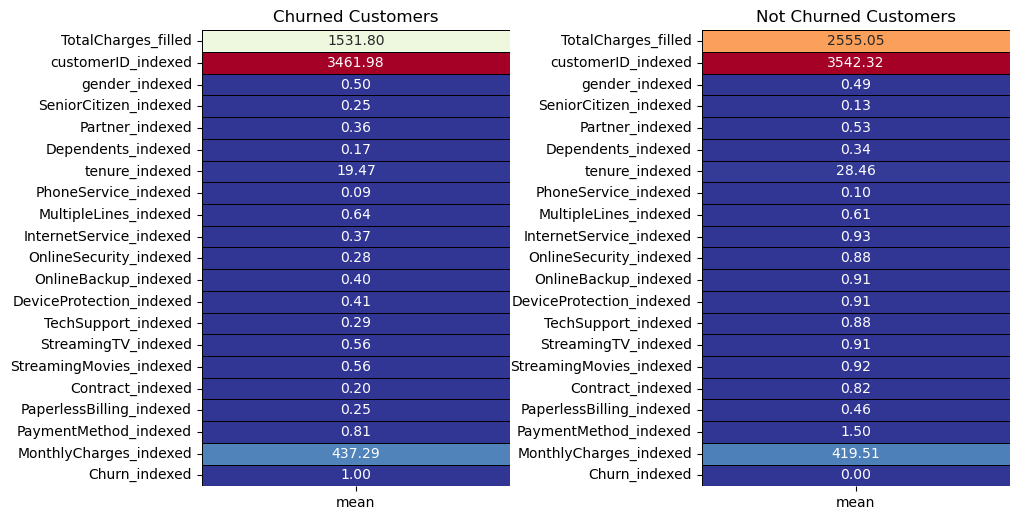

In [14]:
# convert the PySpark DataFrame to a Pandas DataFrame
df_pd = df.toPandas()

# create two dataframes for churned and non-churned customers
churn = df_pd[df_pd['Churn_indexed'] == 1].describe().T
not_churn = df_pd[df_pd['Churn_indexed'] == 0].describe().T

# create a figure with two subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# plot the heatmap for churned customers
sns.heatmap(churn[['mean']], annot=True, cmap='RdYlBu_r', linewidths=0.4, linecolor='black', cbar=False, fmt='.2f', ax=ax[0])
ax[0].set_title('Churned Customers')

# plot the heatmap for non-churned customers
sns.heatmap(not_churn[['mean']], annot=True, cmap='RdYlBu_r', linewidths=0.4, linecolor='black', cbar=False, fmt='.2f', ax=ax[1])
ax[1].set_title('Not Churned Customers')

# adjust the layout of the subplots
fig.tight_layout(pad=0)

# show the plot
plt.show()

In [15]:
# print the schema to see the data types of each column
df.printSchema()

# categorize the columns into numerical and categorical features
categorical_features = []
numerical_features = []
for column, dtype in df.dtypes:
    if dtype == 'string' or dtype == 'boolean':
        categorical_features.append(column)
    else:
        numerical_features.append(column)

print('Categorical Features:', *categorical_features)
print('Numerical Features:', *numerical_features)

root
 |-- TotalCharges_filled: double (nullable = true)
 |-- customerID_indexed: double (nullable = false)
 |-- gender_indexed: double (nullable = false)
 |-- SeniorCitizen_indexed: double (nullable = false)
 |-- Partner_indexed: double (nullable = false)
 |-- Dependents_indexed: double (nullable = false)
 |-- tenure_indexed: double (nullable = false)
 |-- PhoneService_indexed: double (nullable = false)
 |-- MultipleLines_indexed: double (nullable = false)
 |-- InternetService_indexed: double (nullable = false)
 |-- OnlineSecurity_indexed: double (nullable = false)
 |-- OnlineBackup_indexed: double (nullable = false)
 |-- DeviceProtection_indexed: double (nullable = false)
 |-- TechSupport_indexed: double (nullable = false)
 |-- StreamingTV_indexed: double (nullable = false)
 |-- StreamingMovies_indexed: double (nullable = false)
 |-- Contract_indexed: double (nullable = false)
 |-- PaperlessBilling_indexed: double (nullable = false)
 |-- PaymentMethod_indexed: double (nullable = false

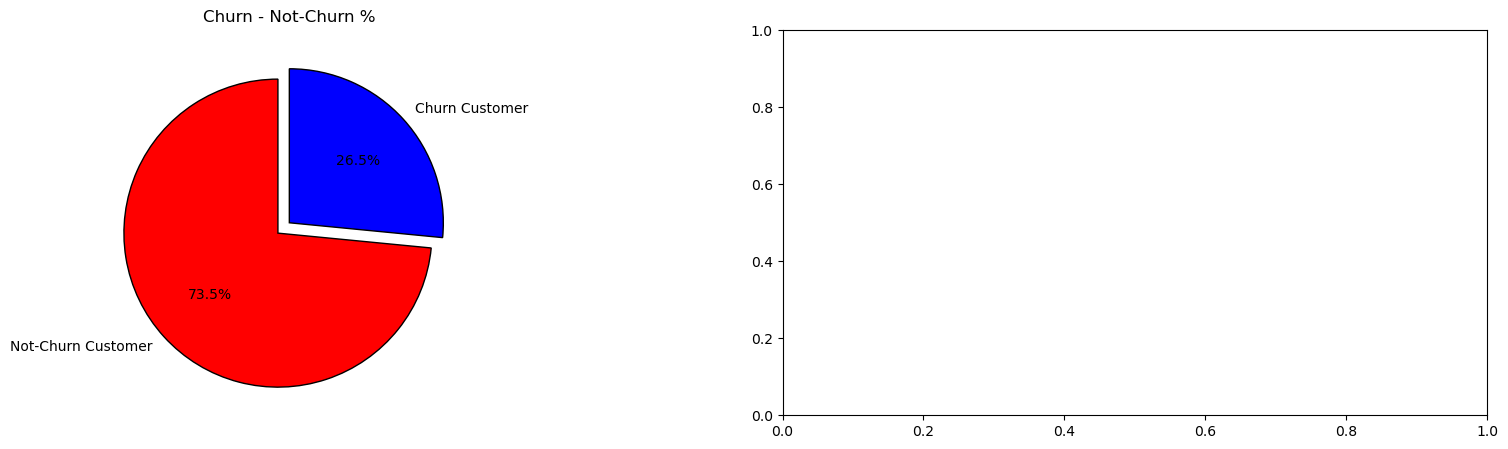

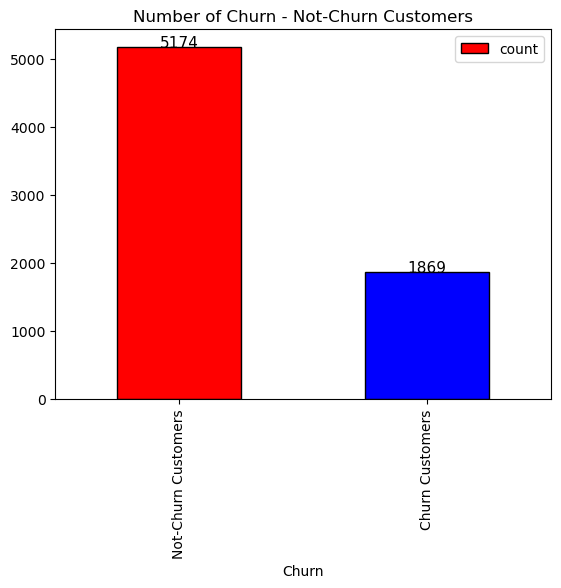

In [16]:
from pyspark.sql.functions import col

# calculate the percentage of churned and non-churned customers
counts = df.groupBy('Churn_indexed').count().withColumn('percentage', col('count') / df.count() * 100)
circle = counts.select('percentage').rdd.flatMap(lambda x: x).collect()

# create a pie chart of churned and non-churned customers
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.pie(circle, labels=['Not-Churn Customer', 'Churn Customer'], autopct='%1.1f%%', startangle=90, explode=(0.1, 0), colors=['red', 'blue'],
       wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'antialiased': True})
plt.title('Churn - Not-Churn %')

# create a bar chart of the number of churned and non-churned customers
plt.subplot(1, 2, 2)
ax = df.groupBy('Churn_indexed').count().withColumn('Churn', when(col('Churn_indexed') == 0, 'Not-Churn Customers').otherwise('Churn Customers')).toPandas().plot(kind='bar', x='Churn', y='count', color=['red', 'blue'], edgecolor='black')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize=11)
ax.set_xticklabels(['Not-Churn Customers', 'Churn Customers'])
plt.title('Number of Churn - Not-Churn Customers')
plt.show()


In [17]:
'''l1 = ['gender','SeniorCitizen','Partner','Dependents'] # Customer Information
l2 = ['PhoneService','MultipleLines','InternetService','StreamingTV','StreamingMovies',
      'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport'] # Services Signed Up for!
l3 = ['Contract','PaperlessBilling','PaymentMethod'] # Payment Information'''

"l1 = ['gender','SeniorCitizen','Partner','Dependents'] # Customer Information\nl2 = ['PhoneService','MultipleLines','InternetService','StreamingTV','StreamingMovies',\n      'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport'] # Services Signed Up for!\nl3 = ['Contract','PaperlessBilling','PaymentMethod'] # Payment Information"

In [18]:
l1 = ['gender_indexed','SeniorCitizen_indexed','Partner_indexed','Dependents_indexed'] # Customer Information
l2 = ['PhoneService_indexed','MultipleLines_indexed','InternetService_indexed','StreamingTV_indexed','StreamingMovies_indexed',
      'OnlineSecurity_indexed','OnlineBackup_indexed','DeviceProtection_indexed','TechSupport_indexed'] # Services Signed Up for!
l3 = ['Contract_indexed','PaperlessBilling_indexed','PaymentMethod_indexed'] # Payment Information



In [19]:
'''We have too many categorical features in this dataset!
We divide them into 3 groups depending on their values or based on the column name!
Group 1 : Customer Information :
gender | SeniorCitizen | Partner | Dependents |'''

'We have too many categorical features in this dataset!\nWe divide them into 3 groups depending on their values or based on the column name!\nGroup 1 : Customer Information :\ngender | SeniorCitizen | Partner | Dependents |'

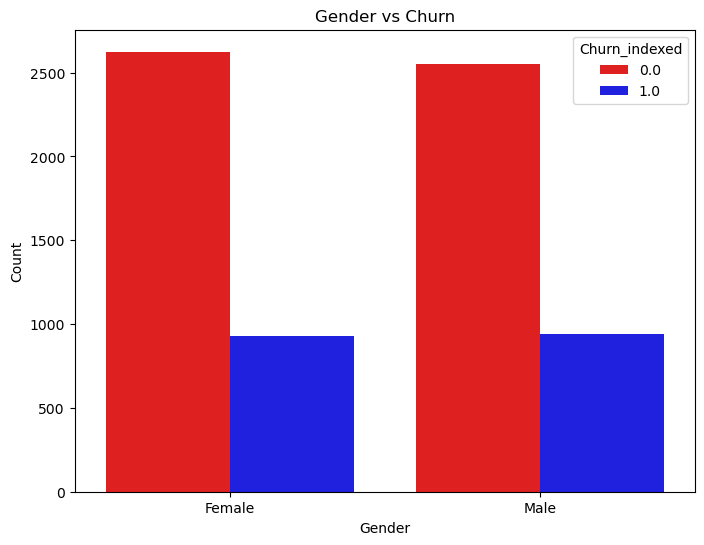

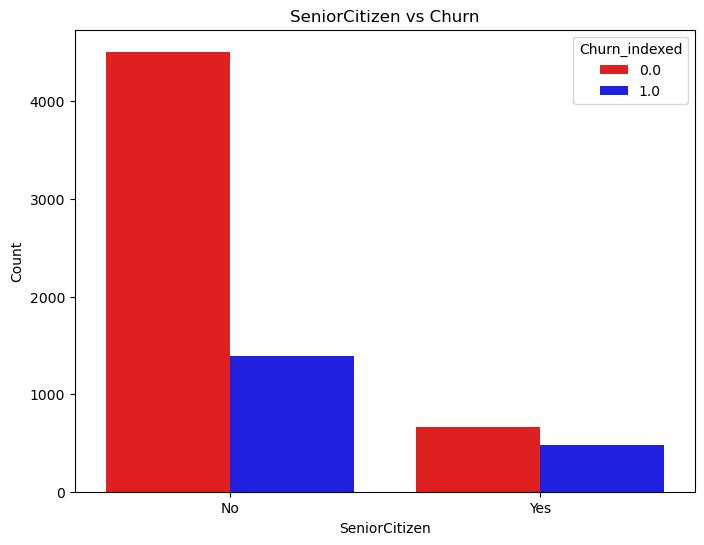

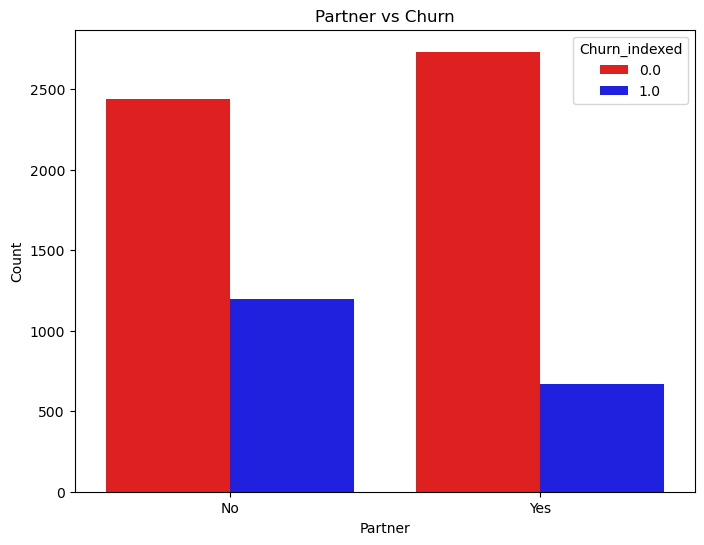

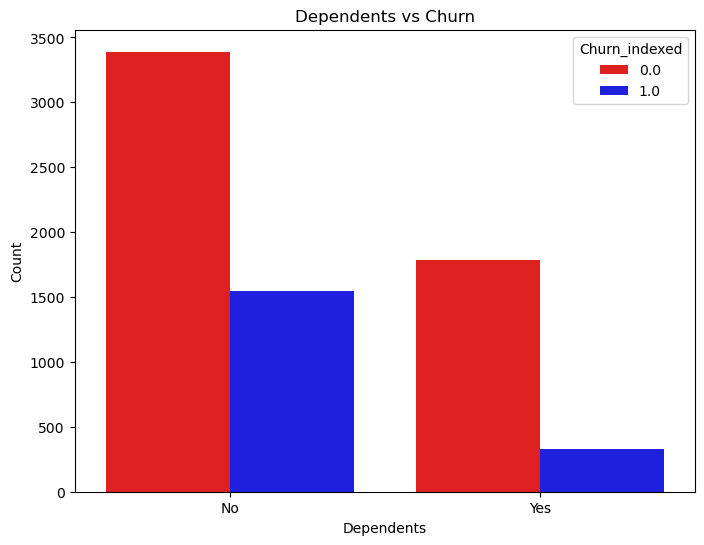

In [20]:

counts = df.groupby(['Churn_indexed', 'gender_indexed']).agg(count('*').alias('count')).orderBy(['Churn_indexed', 'gender_indexed'])
counts_pd = counts.toPandas()

fig = plt.subplots(figsize=(8,6))
sns.barplot(x='gender_indexed', y='count', hue='Churn_indexed', data=counts_pd, palette=['red', 'blue'])
plt.title('Gender vs Churn')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks([0, 1], ['Female', 'Male'])
plt.show()

counts = df.groupby(['Churn_indexed', 'SeniorCitizen_indexed']).agg(count('*').alias('count')).orderBy(['Churn_indexed', 'SeniorCitizen_indexed'])
counts_pd = counts.toPandas()

fig = plt.subplots(figsize=(8,6))
sns.barplot(x='SeniorCitizen_indexed', y='count', hue='Churn_indexed', data=counts_pd, palette=['red', 'blue'])
plt.title('SeniorCitizen vs Churn')
plt.xlabel('SeniorCitizen')
plt.ylabel('Count')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

counts = df.groupby(['Churn_indexed', 'Partner_indexed']).agg(count('*').alias('count')).orderBy(['Churn_indexed', 'Partner_indexed'])
counts_pd = counts.toPandas()

fig = plt.subplots(figsize=(8,6))
sns.barplot(x='Partner_indexed', y='count', hue='Churn_indexed', data=counts_pd, palette=['red', 'blue'])
plt.title('Partner vs Churn')
plt.xlabel('Partner')
plt.ylabel('Count')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

counts = df.groupby(['Churn_indexed', 'Dependents_indexed']).agg(count('*').alias('count')).orderBy(['Churn_indexed', 'Dependents_indexed'])
counts_pd = counts.toPandas()

fig = plt.subplots(figsize=(8,6))
sns.barplot(x='Dependents_indexed', y='count', hue='Churn_indexed', data=counts_pd, palette=['red', 'blue'])
plt.title('Dependents vs Churn')
plt.xlabel('Dependents')
plt.ylabel('Count')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

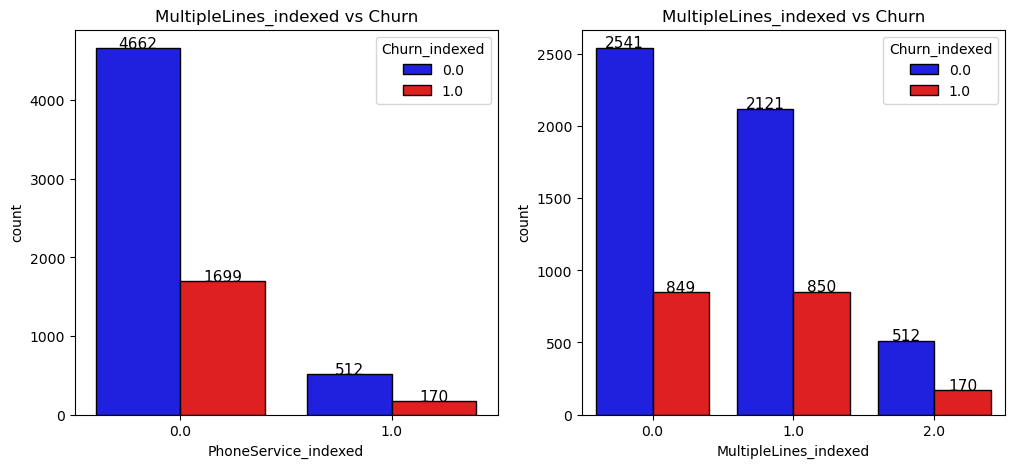

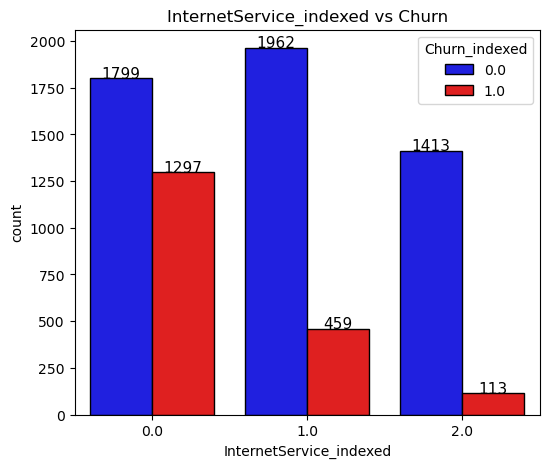

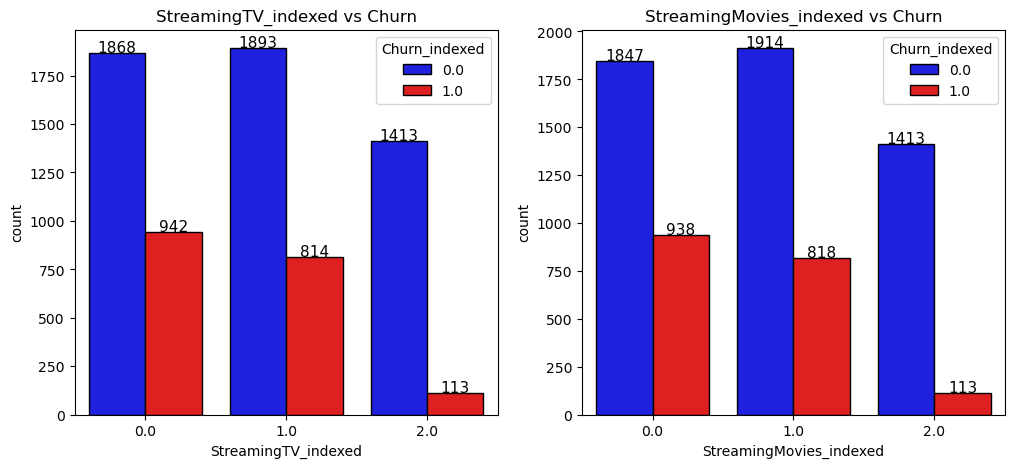

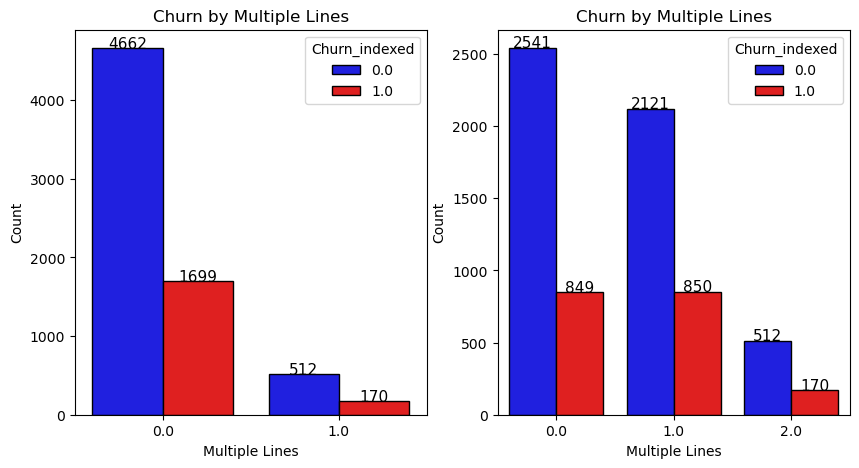

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

for i in range(len(l2[0:2])):
    plt.subplot(1, 2, i + 1)
    ax = sns.countplot(l2[i], data=df.toPandas(), hue="Churn_indexed", palette=['blue', 'red'], edgecolor='black')
    for rect in ax.patches:
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize=11)
    title = l2[1] +' vs Churn'
    plt.title(title)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))

plt.subplot(1, 1, 1)
ax = sns.countplot(l2[2], data=df.toPandas(), hue="Churn_indexed", palette=['blue', 'red'], edgecolor='black')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize=11)
title = l2[2] + ' vs Churn'
plt.title(title)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

for i in range(len(l2[3:5])):
    plt.subplot(1, 2, i + 1)
    ax = sns.countplot(l2[i + 3], data=df.toPandas(), hue="Churn_indexed", palette=['blue', 'red'], edgecolor='black')
    for rect in ax.patches:
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize=11)
    title = l2[i + 3] + ' vs Churn'
    plt.title(title)

# create a list of columns to plot

# create a subplot for each column
fig, ax = plt.subplots(nrows=1, ncols=len(l2[0:2]), figsize=(10, 5))

# plot a countplot for each column
for i in range(len(l2[0:2])):
    plt.subplot(1, 2, i + 1)
    ax = sns.countplot(l2[i], data=df.toPandas(), hue="Churn_indexed", palette=['blue', 'red'], edgecolor='black')
    for rect in ax.patches:
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize=11)
    plt.xlabel('Multiple Lines')
    plt.ylabel('Count')
    plt.title('Churn by Multiple Lines')
plt.show()


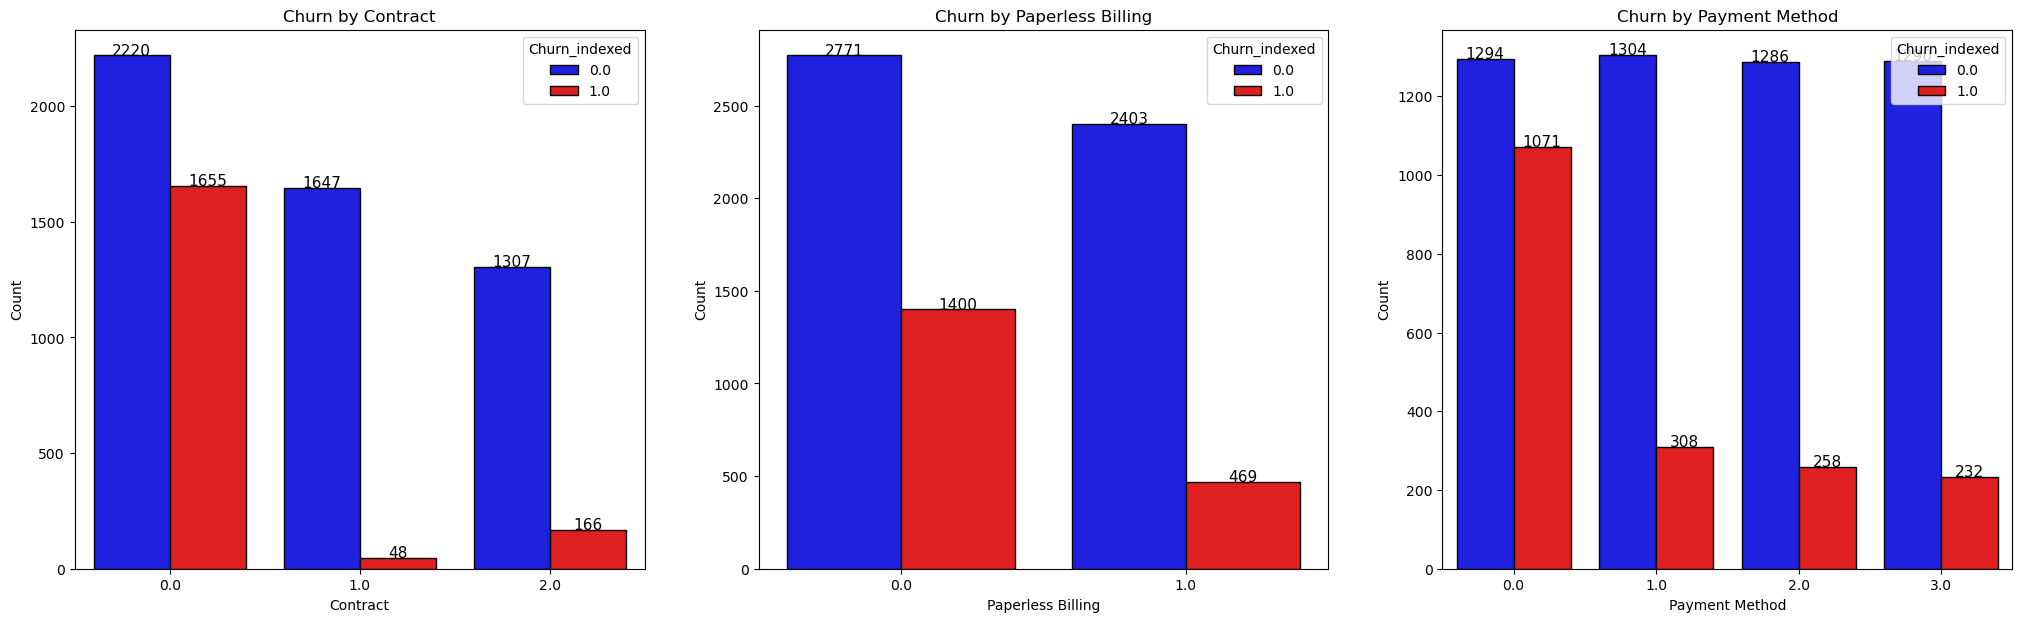

In [22]:
# Convert PySpark DataFrame to Pandas DataFrame
df_pd = df.toPandas()

colors = ['blue', 'red']
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 7))

# Plot for 'Contract_indexed'
plt.subplot(1, 3, 1)
ax = sns.countplot(x=l3[0], data=df_pd, hue="Churn_indexed", palette=colors, edgecolor='black')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize=11)
plt.xlabel('Contract')
plt.ylabel('Count')
plt.title('Churn by Contract')

# Plot for 'PaperlessBilling_indexed'
plt.subplot(1, 3, 2)
ax = sns.countplot(x=l3[1], data=df_pd, hue="Churn_indexed", palette=colors, edgecolor='black')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize=11)
plt.xlabel('Paperless Billing')
plt.ylabel('Count')
plt.title('Churn by Paperless Billing')

# Plot for 'PaymentMethod_indexed'
plt.subplot(1, 3, 3)
ax = sns.countplot(x=l3[2], data=df_pd, hue="Churn_indexed", palette=colors, edgecolor='black')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize=11)
plt.xlabel('Payment Method')
plt.ylabel('Count')
plt.title('Churn by Payment Method')

plt.show()


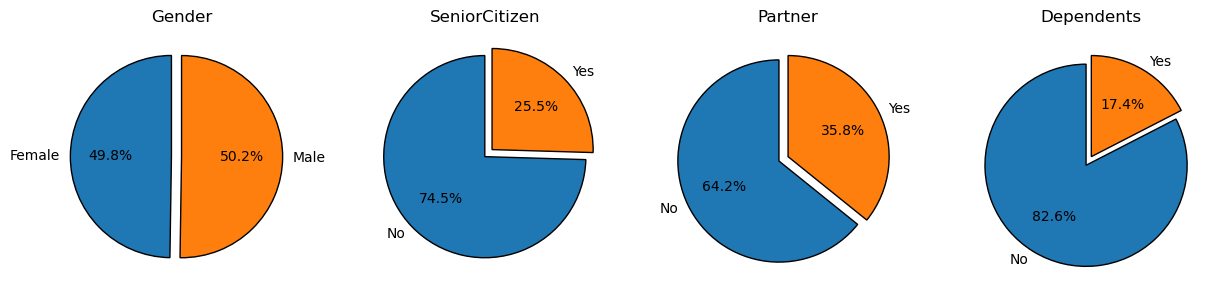

In [23]:

churn_df = df.filter(df['Churn_indexed'] == 1)

# Calculate the percentages for each category
gender = churn_df.groupBy('gender_indexed').count().toPandas()
gender['percentage'] = gender['count'] / gender['count'].sum() * 100

seniorcitizen = churn_df.groupBy('SeniorCitizen_indexed').count().toPandas()
seniorcitizen['percentage'] = seniorcitizen['count'] / seniorcitizen['count'].sum() * 100

partner = churn_df.groupBy('Partner_indexed').count().toPandas()
partner['percentage'] = partner['count'] / partner['count'].sum() * 100

dependents = churn_df.groupBy('Dependents_indexed').count().toPandas()
dependents['percentage'] = dependents['count'] / dependents['count'].sum() * 100

colors = ['tab:blue', 'tab:orange']

gender_labels = {0.0: 'Female', 1.0: 'Male'}
senior_citizen_labels = {0.0: 'No', 1.0: 'Yes'}
partner_labels = {0.0: 'No', 1.0: 'Yes'}
dependents_labels = {0.0: 'No', 1.0: 'Yes'}
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 15))

plt.subplot(1, 4, 1)
plt.pie(gender['percentage'], labels=[gender_labels[index] for index in gender['gender_indexed']], autopct='%1.1f%%', startangle=90, explode=(0.1, 0), colors=colors,
        wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'antialiased': True})
plt.title('Gender')


plt.subplot(1, 4, 2)
plt.pie(seniorcitizen['percentage'], labels=[senior_citizen_labels[index] for index in seniorcitizen['SeniorCitizen_indexed']], autopct='%1.1f%%', startangle=90, explode=(0, 0.1), colors=colors,
        wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'antialiased': True})
plt.title('SeniorCitizen');

plt.subplot(1, 4, 3)
plt.pie(partner['percentage'], labels=[partner_labels[index] for index in partner['Partner_indexed']], autopct='%1.1f%%', startangle=90, explode=(0.1, 0), colors=colors,
        wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'antialiased': True})
plt.title('Partner');

plt.subplot(1, 4, 4)
plt.pie(dependents['percentage'], labels=[dependents_labels[index] for index in dependents['Dependents_indexed']], autopct='%1.1f%%', startangle=90, explode=(0.1, 0), colors=colors,
        wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'antialiased': True})
plt.title('Dependents');

plt.show()


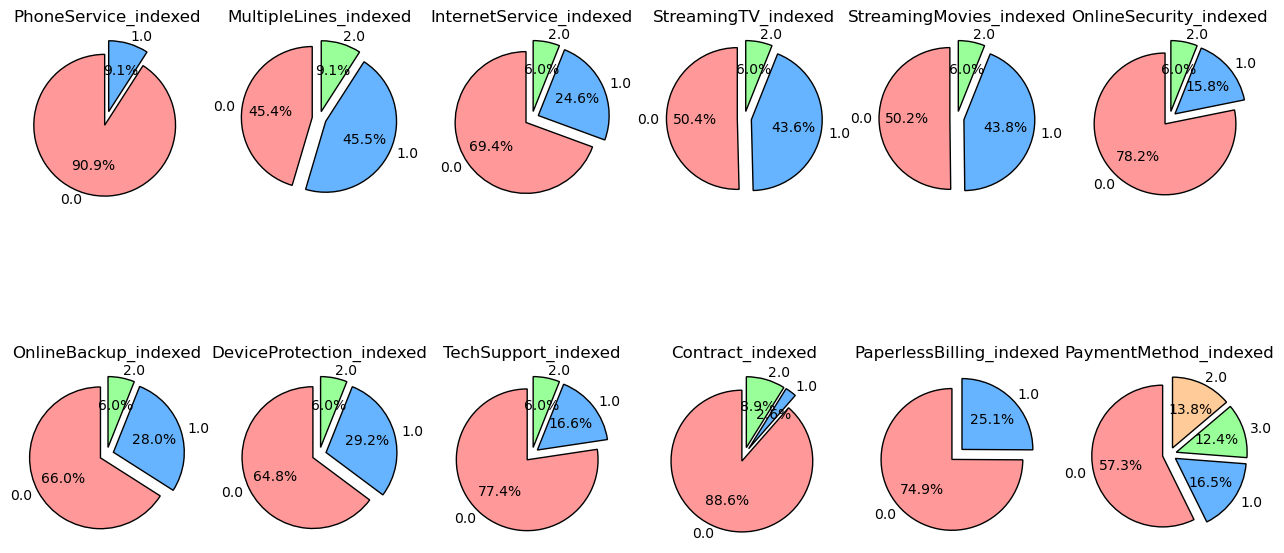

In [24]:
# Filter the churned customers
churned_df = df.filter(df['Churn_indexed'] == 1)

# Analyze the services
services = ['PhoneService_indexed', 'MultipleLines_indexed', 'InternetService_indexed', 'StreamingTV_indexed', 'StreamingMovies_indexed', 'OnlineSecurity_indexed', 'OnlineBackup_indexed', 'DeviceProtection_indexed', 'TechSupport_indexed', 'Contract_indexed', 'PaperlessBilling_indexed', 'PaymentMethod_indexed']

# Calculate the distribution of churned customers for each service
service_distributions = []
for service in services:
    service_dist = churned_df.groupBy(service).count()
    total = service_dist.select(sum("count")).collect()[0][0]
    service_dist = service_dist.withColumn("percentage", (col("count") / total) * 100)
    service_distributions.append(service_dist.toPandas())



fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(16, 8))

# Plot the pie charts
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6']

for idx, service_dist in enumerate(service_distributions):
    # Configure subplot
    ax = axes[idx//6][idx%6]

    # Plot the pie chart
    ax.pie(service_dist["percentage"], labels=service_dist[services[idx]], autopct='%1.1f%%', startangle=90, explode=[0.1]*len(service_dist), colors=colors, wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'antialiased': True})
    ax.set_title(services[idx])

# Display the pie charts
plt.show()


<AxesSubplot:>

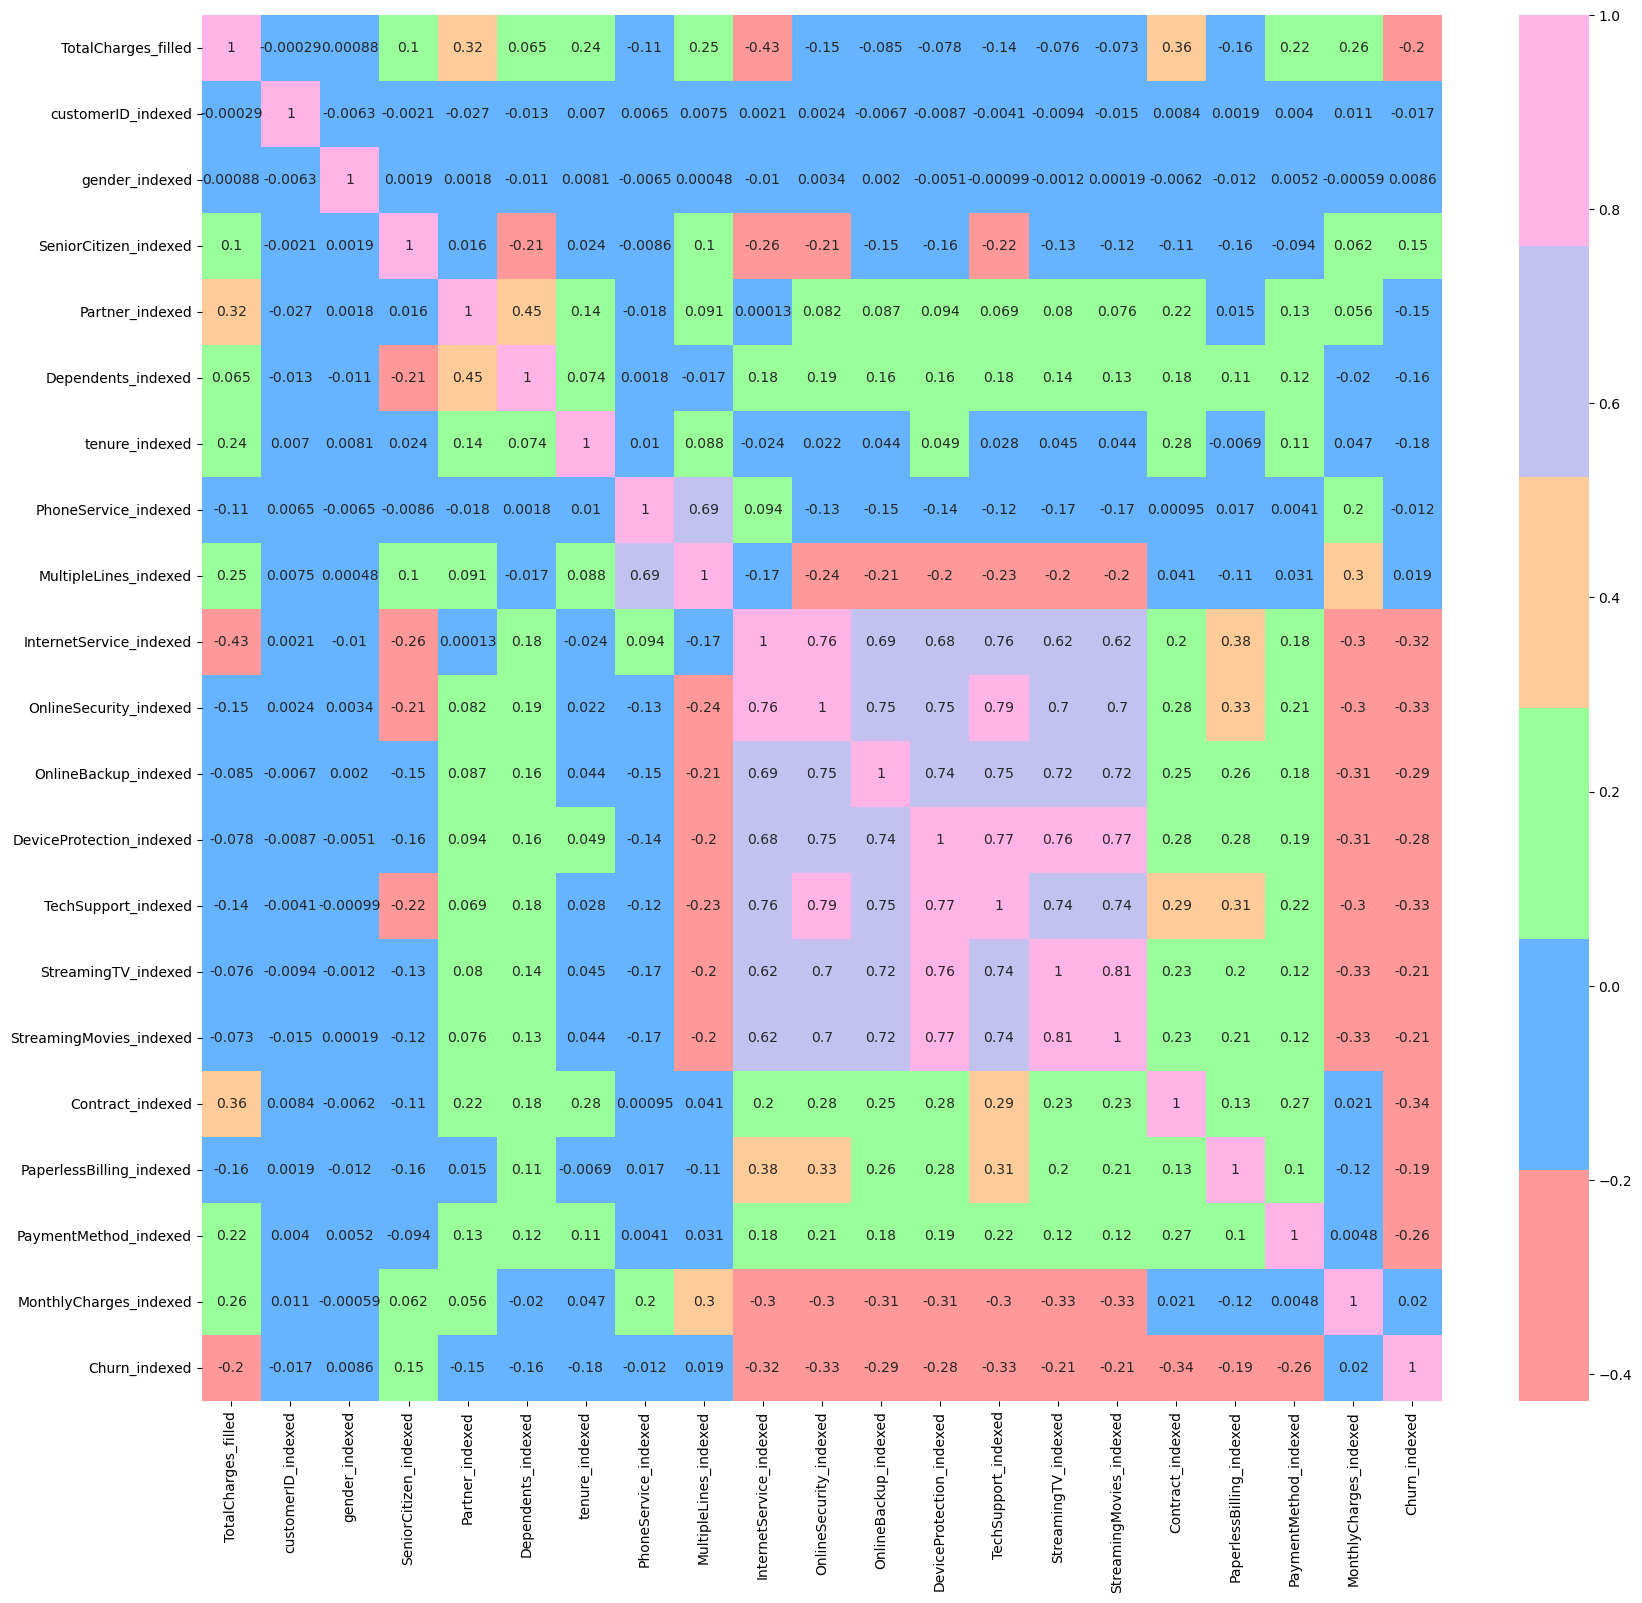

In [25]:
pandas_df = df.toPandas()
fig, ax = plt.subplots(figsize=(20, 18))
sns.heatmap(pandas_df.corr(), cmap=colors, annot=True, ax=ax)


23/05/30 09:55:34 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 09:55:34 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 09:55:34 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


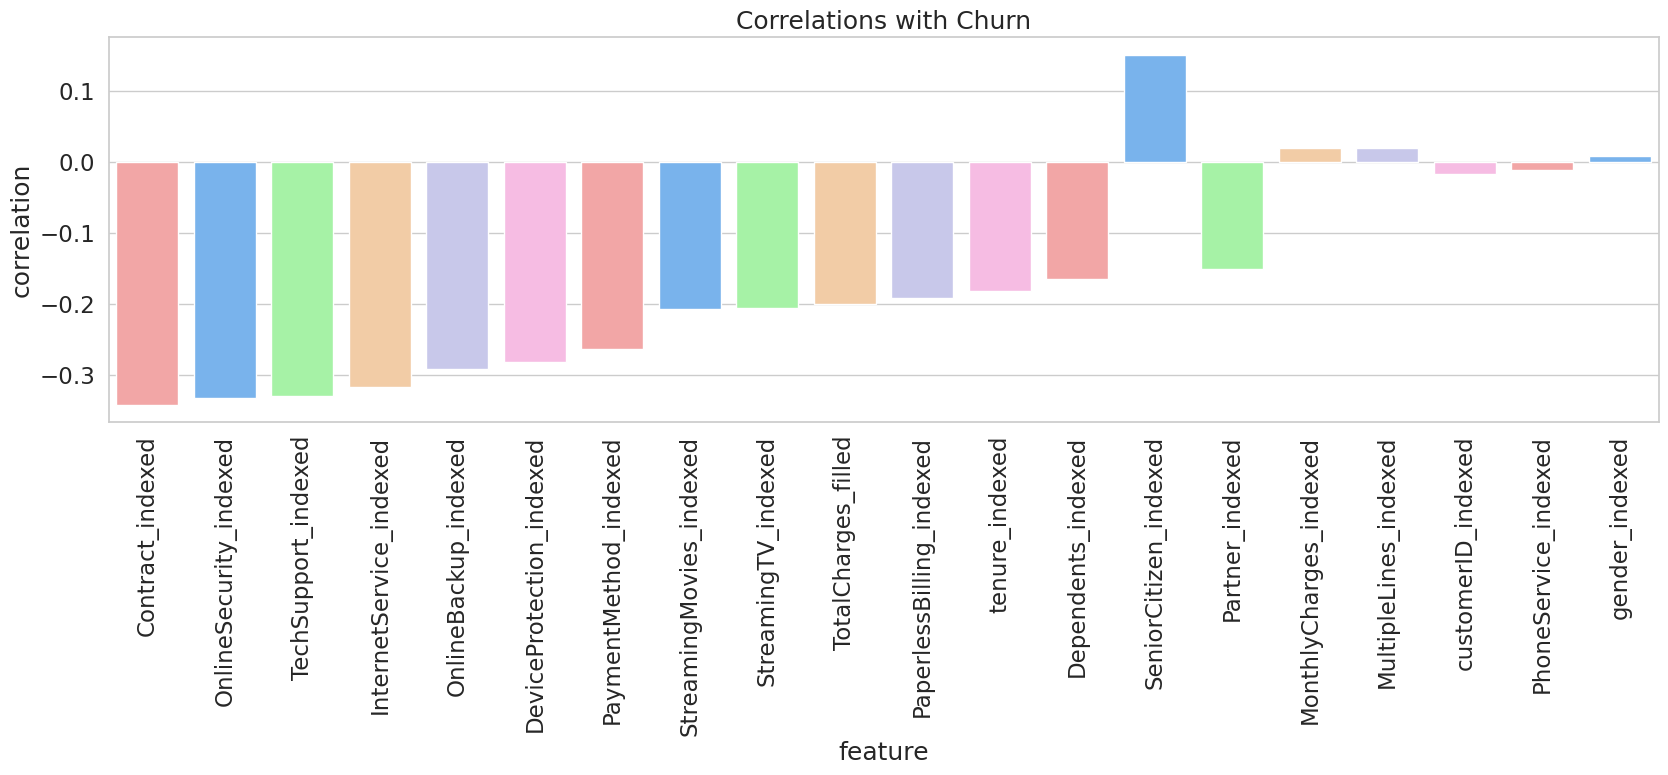

In [26]:
from pyspark.sql.functions import corr

# Calculate the correlations between the features and the target variable
corr_df = df.select([corr(c, 'Churn_indexed').alias(c) for c in df.columns])

# Get the correlations for the target variable and sort them in descending order
corr = corr_df.collect()[0].asDict()
corr.pop('Churn_indexed')
corr = {k: v for k, v in sorted(corr.items(), key=lambda item: -abs(item[1]))}

# Create the heatmap
corr_df = spark.createDataFrame([(k, v) for k, v in corr.items()], ['feature', 'correlation'])
pandas_df = corr_df.toPandas()
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
plt.figure(figsize=(20, 5))
sns.barplot(data=pandas_df, x='feature', y='correlation', palette=colors)
plt.xticks(rotation=90)
plt.title('Correlations with Churn')
plt.show()


In [27]:
#drop col
df1 = df.drop(col("customerID_indexed")).drop(col("PhoneService_indexed")).drop(col("gender_indexed")).drop(col("StreamingTV_indexed")).drop(col("StreamingMovies_indexed")).drop(col("MultipleLines_indexed")).drop(col("InternetService_indexed"))
df1.head()

23/05/30 09:55:35 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 09:55:35 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 09:55:35 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 09:55:35 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Row(TotalCharges_filled=593.3, SeniorCitizen_indexed=0.0, Partner_indexed=1.0, Dependents_indexed=1.0, tenure_indexed=10.0, OnlineSecurity_indexed=0.0, OnlineBackup_indexed=1.0, DeviceProtection_indexed=0.0, TechSupport_indexed=1.0, Contract_indexed=2.0, PaperlessBilling_indexed=0.0, PaymentMethod_indexed=1.0, MonthlyCharges_indexed=359.0, Churn_indexed=0.0)

In [28]:
#Balancing the Data 
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)
# Split the data into positive and negative cases
positive_cases = df.filter(df['Churn_indexed'] == 1)
negative_cases = df.filter(df['Churn_indexed'] == 0)

# Calculate the ratio of positive to negative cases
ratio = positive_cases.count() / negative_cases.count()

# Sample the negative cases
sampled_negative_cases = negative_cases.sampleBy('Churn_indexed', fractions={0: ratio})

# Combine the positive and negative cases
balanced_df = positive_cases.union(sampled_negative_cases)


In [29]:
balanced_df.groupBy('Churn_indexed').count().show()


+-------------+-----+
|Churn_indexed|count|
+-------------+-----+
|          1.0| 1869|
|          0.0| 1884|
+-------------+-----+



In [30]:
balanced_df.printSchema()

root
 |-- TotalCharges_filled: double (nullable = true)
 |-- customerID_indexed: double (nullable = false)
 |-- gender_indexed: double (nullable = false)
 |-- SeniorCitizen_indexed: double (nullable = false)
 |-- Partner_indexed: double (nullable = false)
 |-- Dependents_indexed: double (nullable = false)
 |-- tenure_indexed: double (nullable = false)
 |-- PhoneService_indexed: double (nullable = false)
 |-- MultipleLines_indexed: double (nullable = false)
 |-- InternetService_indexed: double (nullable = false)
 |-- OnlineSecurity_indexed: double (nullable = false)
 |-- OnlineBackup_indexed: double (nullable = false)
 |-- DeviceProtection_indexed: double (nullable = false)
 |-- TechSupport_indexed: double (nullable = false)
 |-- StreamingTV_indexed: double (nullable = false)
 |-- StreamingMovies_indexed: double (nullable = false)
 |-- Contract_indexed: double (nullable = false)
 |-- PaperlessBilling_indexed: double (nullable = false)
 |-- PaymentMethod_indexed: double (nullable = false

In [31]:
balanced_df = balanced_df.drop('customerID_indexed')

In [32]:
dt = DecisionTreeClassifier(labelCol='Churn_indexed', featuresCol='features')
rf = RandomForestClassifier(labelCol='Churn_indexed', featuresCol='features')
gbt = GBTClassifier(labelCol='Churn_indexed', featuresCol='features')
lr = LogisticRegression(labelCol='Churn_indexed', featuresCol='features')

In [33]:
categorical_features = [(col, train_data.select(col).distinct().count()) for col in train_data.columns if train_data.select(col).distinct().count() < 100]
print("Categorical Features and their unique values count:", categorical_features)
string_indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_index") for col, _ in categorical_features]
input_columns = [f"{col}_index" if col in dict(categorical_features).keys() else col for col in train_data.columns if col != 'Churn_indexed']

# Create the new VectorAssembler
assembler = VectorAssembler(inputCols=input_columns, outputCol='features')

# Update the pipelines to include only the new assembler
dt_pipeline = Pipeline(stages=string_indexers + [assembler, dt])
rf_pipeline = Pipeline(stages=string_indexers + [assembler, rf])
gbt_pipeline = Pipeline(stages=string_indexers + [assembler, gbt])
lr_pipeline = Pipeline(stages=string_indexers + [assembler, lr])


23/05/30 09:55:37 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 09:55:38 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 09:55:38 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 09:55:38 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 09:55:38 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

Categorical Features and their unique values count: [('gender_indexed', 2), ('SeniorCitizen_indexed', 2), ('Partner_indexed', 2), ('Dependents_indexed', 2), ('tenure_indexed', 73), ('PhoneService_indexed', 2), ('MultipleLines_indexed', 3), ('InternetService_indexed', 3), ('OnlineSecurity_indexed', 3), ('OnlineBackup_indexed', 3), ('DeviceProtection_indexed', 3), ('TechSupport_indexed', 3), ('StreamingTV_indexed', 3), ('StreamingMovies_indexed', 3), ('Contract_indexed', 3), ('PaperlessBilling_indexed', 2), ('PaymentMethod_indexed', 4), ('Churn_indexed', 2)]


In [34]:
from pyspark.sql.functions import countDistinct

max_distinct_count = 0
max_distinct_column = ''

for column in balanced_df.columns:
    distinct_count = balanced_df.select(countDistinct(column)).collect()[0][0]
    if distinct_count > max_distinct_count:
        max_distinct_count = distinct_count
        max_distinct_column = column

print(f"Column with the highest number of distinct values: {max_distinct_column}")
print(f"Number of distinct values: {max_distinct_count}")


23/05/30 09:56:02 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 09:56:02 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 09:56:02 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 09:56:02 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 09:56:02 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

Column with the highest number of distinct values: TotalCharges_filled
Number of distinct values: 3508


In [35]:
evaluator = BinaryClassificationEvaluator(labelCol='Churn_indexed')

assembler = VectorAssembler(
    inputCols=[
        "TotalCharges_filled", "gender_indexed",
        "SeniorCitizen_indexed", "Partner_indexed", "Dependents_indexed",
        "tenure_indexed", "PhoneService_indexed", "MultipleLines_indexed",
        "InternetService_indexed", "OnlineSecurity_indexed", "OnlineBackup_indexed",
        "DeviceProtection_indexed", "TechSupport_indexed", "StreamingTV_indexed",
        "StreamingMovies_indexed", "Contract_indexed", "PaperlessBilling_indexed",
        "PaymentMethod_indexed", "MonthlyCharges_indexed"],
    outputCol="features")


In [36]:
# Decision Tree Classifier
dt = DecisionTreeClassifier(labelCol='Churn_indexed', featuresCol='features', maxBins=max_distinct_count + 1)
dt_pipeline = Pipeline(stages=[assembler, dt])
dt_paramGrid = ParamGridBuilder().addGrid(dt.maxDepth, [3, 5, 7]).build()
dt_crossval = CrossValidator(estimator=dt_pipeline, estimatorParamMaps=dt_paramGrid, evaluator=evaluator, numFolds=3)

dt_start = time.time()
dt_model = dt_crossval.fit(train_data)
dt_end = time.time()
dt_predictions = dt_model.transform(test_data)

dtev_start = time.time()
dt_auc = evaluator.evaluate(dt_predictions)
dtev_end = time.time()

print(f"Decision Tree AUC: {dt_auc:.4f}")


23/05/30 09:56:11 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 09:56:12 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 09:56:21 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 09:56:22 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 09:56:28 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

Decision Tree AUC: 0.7506


In [37]:
# Random Forest Classifier
rf = RandomForestClassifier(labelCol='Churn_indexed', featuresCol='features', maxBins=max_distinct_count + 1)
rf_pipeline = Pipeline(stages=[assembler, rf])
rf_paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [10, 50, 100]).build()
rf_crossval = CrossValidator(estimator=rf_pipeline, estimatorParamMaps=rf_paramGrid, evaluator=evaluator, numFolds=3)

rf_start = time.time()
rf_model = rf_crossval.fit(train_data)
rf_end = time.time()
rf_predictions = rf_model.transform(test_data)
rfev_start = time.time()
rf_auc = evaluator.evaluate(rf_predictions)
rfev_end = time.time()
print(f"Random Forest AUC: {rf_auc:.4f}")


23/05/30 09:56:37 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 09:56:37 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 09:56:43 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1353.7 KiB
23/05/30 09:56:45 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1766.7 KiB
23/05/30 09:56:48 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1855.0 KiB
23/05/30 09:56:50 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1408.9 KiB
23/05/30 09:56:52 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/05/30 09:56:55

Random Forest AUC: 0.7833


In [38]:
# Gradient-Boosted Trees Classifier
gbt = GBTClassifier(labelCol='Churn_indexed', featuresCol='features', maxBins=max_distinct_count + 1)
gbt_pipeline = Pipeline(stages=[assembler, gbt])
gbt_paramGrid = ParamGridBuilder().addGrid(gbt.maxIter, [10, 20, 30]).build()
gbt_crossval = CrossValidator(estimator=gbt_pipeline, estimatorParamMaps=gbt_paramGrid, evaluator=evaluator, numFolds=3)

gbt_start = time.time()
gbt_model = gbt_crossval.fit(train_data)
gbt_end = time.time()
gbt_predictions = gbt_model.transform(test_data)
gbtev_start = time.time()
gbt_auc = evaluator.evaluate(gbt_predictions)
gbtev_end = time.time()
print(f"Gradient-Boosted Trees AUC: {gbt_auc:.4f}")


23/05/30 09:58:03 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 09:58:03 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 09:58:09 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1004.2 KiB
23/05/30 09:58:09 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1021.2 KiB
23/05/30 09:58:09 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1022.6 KiB
23/05/30 09:58:09 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1045.5 KiB
23/05/30 09:58:10 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1065.7 KiB
23/05/30 09:58

Gradient-Boosted Trees AUC: 0.6903


In [39]:
# Logistic Regression Classifier
lr = LogisticRegression(labelCol='Churn_indexed', featuresCol='features')
lr_pipeline = Pipeline(stages=[assembler, lr])
lr_paramGrid = ParamGridBuilder().addGrid(lr.regParam, [0.1, 0.01]).build()
lr_crossval = CrossValidator(estimator=lr_pipeline, estimatorParamMaps=lr_paramGrid, evaluator=evaluator, numFolds=3)

lr_start = time.time()
lr_model = lr_crossval.fit(train_data)
lr_end = time.time()
lr_predictions = lr_model.transform(test_data)
lrev_start = time.time()
lr_auc = evaluator.evaluate(lr_predictions)
lrev_end = time.time()
print(f"Logistic Regression AUC: {lr_auc:.4f}")


23/05/30 10:01:18 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:01:19 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:01:26 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:01:26 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:01:31 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

Logistic Regression AUC: 0.8335


In [40]:
print("Time taking to train Decision Tree Classifier: ", {dt_end - dt_start}, "sec")
print("Time taking to evaluate Decision Tree Classifier: ", {dtev_end - dtev_start}, "sec")

print("Time taking to train Random Forest Classifier: ", {rf_end - rf_start}, "sec")
print("Time taking to evaluate Random Forest Classifier: ", {rfev_end - rfev_start}, "sec")

print("Time taking to train Gradient-Boosted Trees Classifier: ", {gbt_end - gbt_start}, "sec")
print("Time taking to evaluate Gradient-Boosted Trees Classifier: ", {gbtev_end - gbtev_start}, "sec")

print("Time taking to train Logistic Regression Classifier: ", {lr_end - lr_start}, "sec")
print("Time taking to evaluate Logistic Regression Classifier: ", {lrev_end - lrev_start}, "sec")


Time taking to train Decision Tree Classifier:  {24.474844217300415} sec
Time taking to evaluate Decision Tree Classifier:  {0.7030453681945801} sec
Time taking to train Random Forest Classifier:  {85.01655411720276} sec
Time taking to evaluate Random Forest Classifier:  {1.0312061309814453} sec
Time taking to train Gradient-Boosted Trees Classifier:  {194.6539249420166} sec
Time taking to evaluate Gradient-Boosted Trees Classifier:  {0.8468494415283203} sec
Time taking to train Logistic Regression Classifier:  {20.256380319595337} sec
Time taking to evaluate Logistic Regression Classifier:  {0.5668740272521973} sec


In [41]:
best_model = max([(dt_model, dt_auc), (rf_model, rf_auc), (gbt_model, gbt_auc), (lr_model, lr_auc)], key=lambda x: x[1])
print(f"Best model: {type(best_model[0].bestModel.stages[-1])}, AUC: {best_model[1]:.4f}")


Best model: <class 'pyspark.ml.classification.LogisticRegressionModel'>, AUC: 0.8335


In [42]:
new_predictions = best_model[0].transform(test_data)
new_predictions.select('features', 'rawPrediction', 'probability', 'prediction').show()


23/05/30 10:01:39 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:01:39 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:01:39 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/05/30 10:01:40 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:01:40 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause seriou

+--------------------+--------------------+--------------------+----------+
|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|(19,[0,8,9,10,11,...|[1.51405533985085...|[0.81966143054291...|       0.0|
|(19,[0,1,8,9,10,1...|[1.45140619559699...|[0.81021475451862...|       0.0|
|(19,[0,8,9,10,11,...|[1.76804359811097...|[0.85421420463780...|       0.0|
|(19,[0,8,9,10,11,...|[1.56425203201604...|[0.82696264547850...|       0.0|
|(19,[0,8,9,10,11,...|[1.46775676038298...|[0.81271618519294...|       0.0|
|(19,[0,1,8,9,10,1...|[1.44726229473391...|[0.80957674086515...|       0.0|
|(19,[0,8,9,10,11,...|[1.76426385574018...|[0.85374287416320...|       0.0|
|[19.55,0.0,0.0,0....|[1.99302419928334...|[0.88006271589413...|       0.0|
|(19,[0,8,9,10,11,...|[1.96355991809332...|[0.87691770108818...|       0.0|
|(19,[0,8,9,10,11,...|[1.76243886284136...|[0.85351484749249...|       0.0|
|[19.65,0.0,

23/05/30 10:01:40 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:01:40 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:01:45 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:01:45 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:01:51 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

Decision Tree AUC (Partitions=2): 0.6944
Time taken (Partitions=2): 17.80 seconds
Evaluation time (Partitions=2): 0.69 seconds


23/05/30 10:01:59 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:01:59 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:02:04 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:02:04 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:02:10 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

Decision Tree AUC (Partitions=4): 0.6944
Time taken (Partitions=4): 18.36 seconds
Evaluation time (Partitions=4): 0.61 seconds


23/05/30 10:02:18 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:02:18 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:02:24 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:02:24 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:02:31 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

Decision Tree AUC (Partitions=8): 0.6944
Time taken (Partitions=8): 22.68 seconds
Evaluation time (Partitions=8): 0.96 seconds


23/05/30 10:02:41 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:02:41 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:02:52 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:02:52 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:03:01 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

Decision Tree AUC (Partitions=16): 0.6944
Time taken (Partitions=16): 32.34 seconds
Evaluation time (Partitions=16): 0.92 seconds


23/05/30 10:03:15 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:03:15 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:03:28 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:03:28 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:03:41 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

Decision Tree AUC (Partitions=32): 0.6944
Time taken (Partitions=32): 43.65 seconds
Evaluation time (Partitions=32): 1.11 seconds


23/05/30 10:04:00 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:04:00 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:04:11 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:04:11 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:04:22 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

Random Forest AUC (Partitions=2): 0.7725
Time taken (Partitions=2): 39.37 seconds
Evaluation time (Partitions=2): 0.77 seconds


23/05/30 10:04:40 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:04:40 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:04:52 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:04:52 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:05:05 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

Random Forest AUC (Partitions=4): 0.7530
Time taken (Partitions=4): 43.06 seconds
Evaluation time (Partitions=4): 1.00 seconds


23/05/30 10:05:24 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:05:24 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:05:39 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:05:39 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:05:54 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

Random Forest AUC (Partitions=8): 0.7839
Time taken (Partitions=8): 51.28 seconds
Evaluation time (Partitions=8): 1.13 seconds


23/05/30 10:06:16 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:06:16 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:06:38 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:06:38 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:06:58 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

Random Forest AUC (Partitions=16): 0.7750
Time taken (Partitions=16): 70.43 seconds
Evaluation time (Partitions=16): 1.29 seconds


23/05/30 10:07:28 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:07:28 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:07:59 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:08:00 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:08:32 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

Random Forest AUC (Partitions=32): 0.7648
Time taken (Partitions=32): 107.47 seconds
Evaluation time (Partitions=32): 1.98 seconds


23/05/30 10:09:18 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:09:18 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:09:27 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1001.3 KiB
23/05/30 10:09:27 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1003.5 KiB
23/05/30 10:09:28 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1030.3 KiB
23/05/30 10:09:28 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1046.6 KiB
23/05/30 10:09:28 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1055.6 KiB
23/05/30 10:09

Gradient-Boosted Trees AUC (Partitions=2): 0.6829
Time taken (Partitions=2): 188.99 seconds
Evaluation time (Partitions=2): 0.78 seconds


23/05/30 10:12:28 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:12:28 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:12:40 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1026.2 KiB
23/05/30 10:12:41 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1034.2 KiB
23/05/30 10:12:41 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1048.6 KiB
23/05/30 10:12:41 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1065.7 KiB
23/05/30 10:12:41 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1067.1 KiB
23/05/30 10:12

Gradient-Boosted Trees AUC (Partitions=4): 0.6829
Time taken (Partitions=4): 245.37 seconds
Evaluation time (Partitions=4): 0.91 seconds


23/05/30 10:16:34 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:16:34 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:16:49 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1011.2 KiB
23/05/30 10:16:50 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1043.0 KiB
23/05/30 10:16:50 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1068.8 KiB
23/05/30 10:16:50 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1085.8 KiB
23/05/30 10:16:51 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1088.0 KiB
23/05/30 10:16

Gradient-Boosted Trees AUC (Partitions=8): 0.6829
Time taken (Partitions=8): 359.66 seconds
Evaluation time (Partitions=8): 1.12 seconds


23/05/30 10:22:35 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:22:35 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:23:00 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1017.8 KiB
23/05/30 10:23:00 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1034.9 KiB
23/05/30 10:23:00 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1036.2 KiB
23/05/30 10:23:01 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1062.2 KiB
23/05/30 10:23:02 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1073.0 KiB
23/05/30 10:23

Gradient-Boosted Trees AUC (Partitions=16): 0.6829
Time taken (Partitions=16): 578.96 seconds
Evaluation time (Partitions=16): 1.66 seconds


23/05/30 10:32:16 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:32:16 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:32:58 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1004.6 KiB
23/05/30 10:32:59 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1006.6 KiB
23/05/30 10:33:00 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1034.6 KiB
23/05/30 10:33:01 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1045.2 KiB
23/05/30 10:33:03 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1057.5 KiB
23/05/30 10:33

Gradient-Boosted Trees AUC (Partitions=32): 0.6829
Time taken (Partitions=32): 1001.33 seconds
Evaluation time (Partitions=32): 2.50 seconds


23/05/30 10:48:59 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:49:00 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:49:04 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:49:04 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:49:09 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

Logistic Regression AUC (Partitions=2): 0.8346
Time taken (Partitions=2): 18.07 seconds
Evaluation time (Partitions=2): 0.58 seconds


23/05/30 10:49:18 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:49:18 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:49:23 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:49:24 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:49:29 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

Logistic Regression AUC (Partitions=4): 0.8346
Time taken (Partitions=4): 20.13 seconds
Evaluation time (Partitions=4): 0.66 seconds


23/05/30 10:49:39 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:49:39 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:49:50 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:49:50 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:50:00 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

Logistic Regression AUC (Partitions=8): 0.8346
Time taken (Partitions=8): 38.91 seconds
Evaluation time (Partitions=8): 0.80 seconds


23/05/30 10:50:19 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:50:19 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:50:35 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:50:35 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:50:51 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

Logistic Regression AUC (Partitions=16): 0.8346
Time taken (Partitions=16): 60.18 seconds
Evaluation time (Partitions=16): 0.97 seconds


23/05/30 10:51:20 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:51:20 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:51:44 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:51:44 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/30 10:52:07 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

Logistic Regression AUC (Partitions=32): 0.8346
Time taken (Partitions=32): 88.14 seconds
Evaluation time (Partitions=32): 1.43 seconds


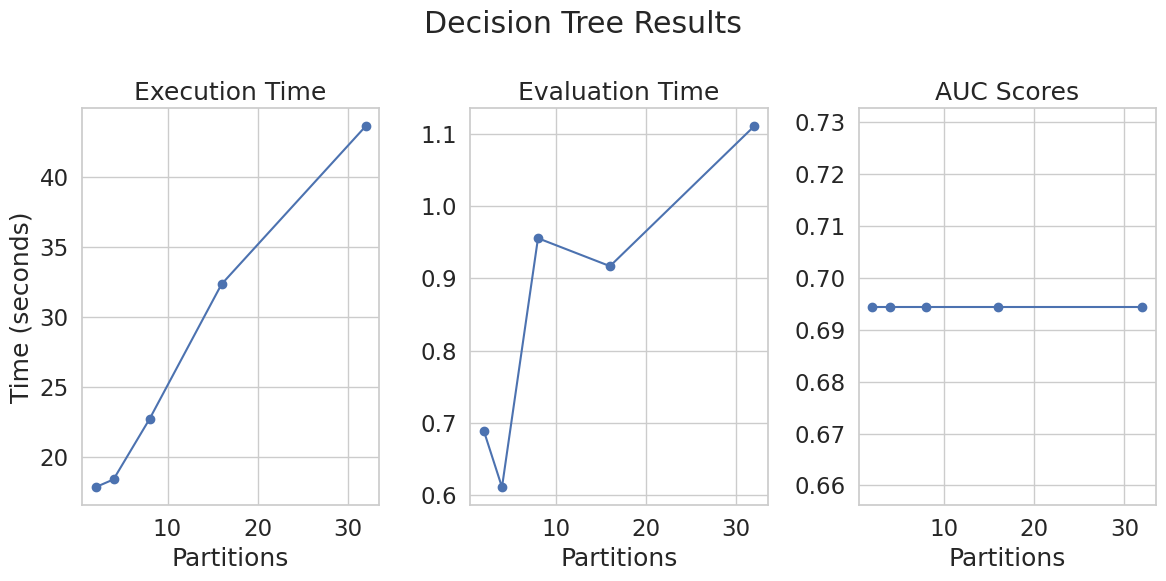

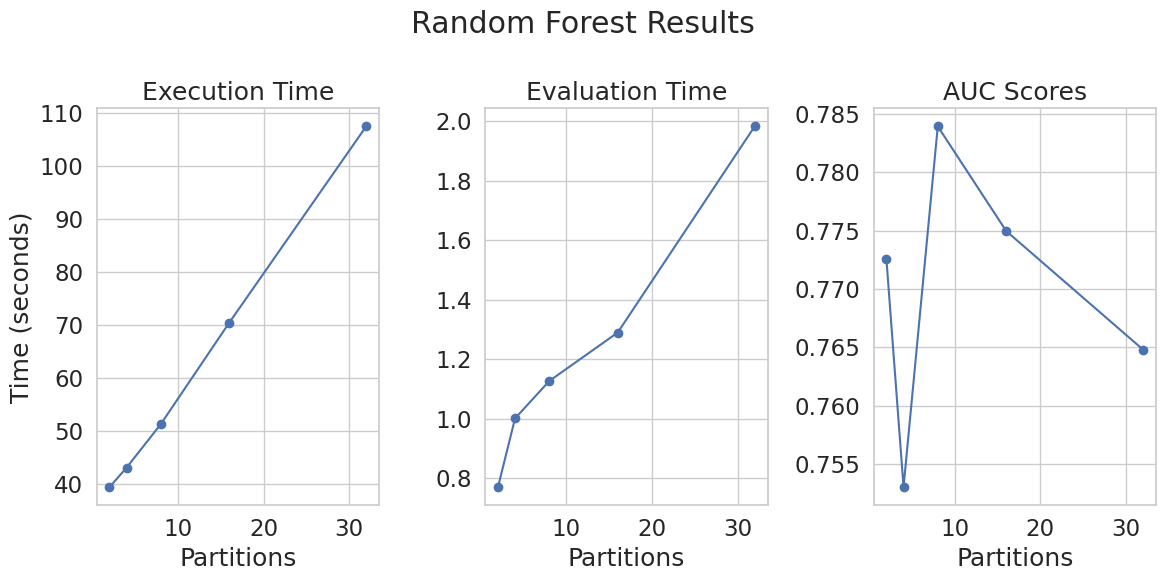

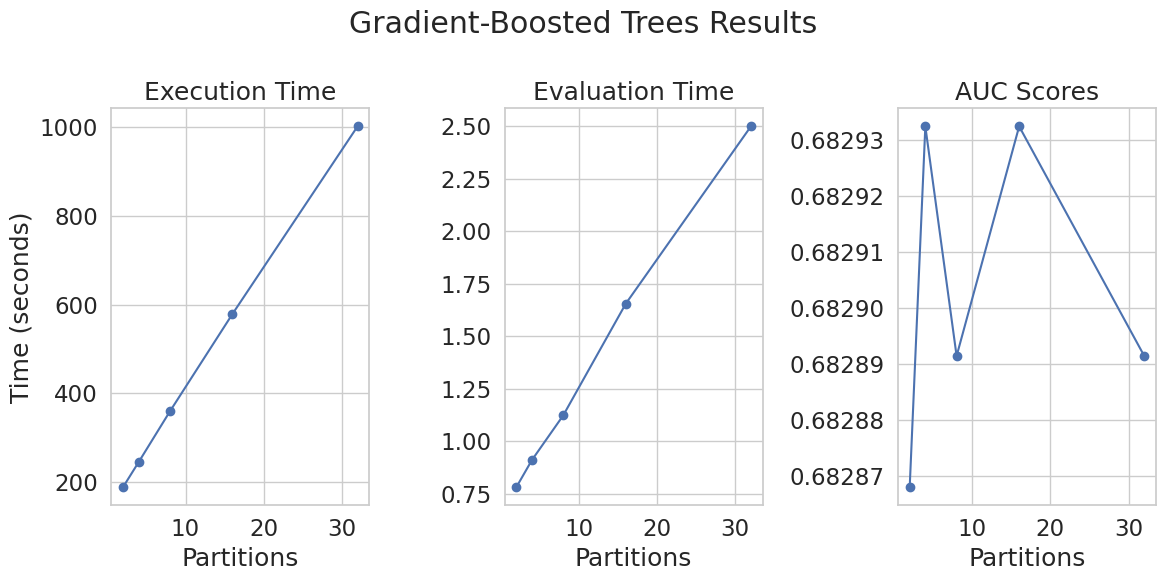

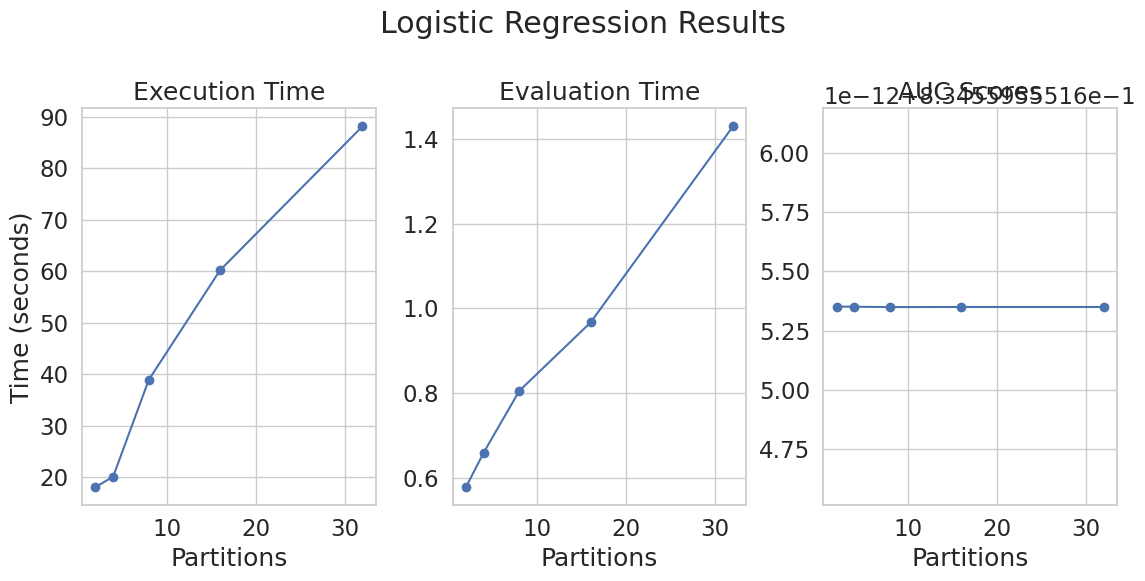

In [43]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, LogisticRegression
import time
import matplotlib.pyplot as plt

spark = (
    SparkSession.builder
    .config('spark.driver.memory', '4g')
    .config('spark.network.timeout', '600s')
    .getOrCreate()
)

evaluator = BinaryClassificationEvaluator(labelCol='Churn_indexed')

assembler = VectorAssembler(
    inputCols=[
        "TotalCharges_filled", "gender_indexed",
        "SeniorCitizen_indexed", "Partner_indexed", "Dependents_indexed",
        "tenure_indexed", "PhoneService_indexed", "MultipleLines_indexed",
        "InternetService_indexed", "OnlineSecurity_indexed", "OnlineBackup_indexed",
        "DeviceProtection_indexed", "TechSupport_indexed", "StreamingTV_indexed",
        "StreamingMovies_indexed", "Contract_indexed", "PaperlessBilling_indexed",
        "PaymentMethod_indexed", "MonthlyCharges_indexed"],
    outputCol="features")

num_partitions = [2, 4, 8, 16, 32]

results = {
    'Decision Tree': {},
    'Random Forest': {},
    'Gradient-Boosted Trees': {},
    'Logistic Regression': {}
}

# Repeat the following for each model
for model_name, model, paramGrid in [('Decision Tree', DecisionTreeClassifier(labelCol='Churn_indexed', featuresCol='features', maxBins=max_distinct_count + 1), ParamGridBuilder().addGrid(dt.maxDepth, [3, 5, 7]).build()),
                                     ('Random Forest', RandomForestClassifier(labelCol='Churn_indexed', featuresCol='features', maxBins=max_distinct_count + 1), ParamGridBuilder().addGrid(rf.numTrees, [10, 50, 100]).build()),
                                     ('Gradient-Boosted Trees', GBTClassifier(labelCol='Churn_indexed', featuresCol='features', maxBins=max_distinct_count + 1), ParamGridBuilder().addGrid(gbt.maxIter, [10, 20, 30]).build()),
                                     ('Logistic Regression', LogisticRegression(labelCol='Churn_indexed', featuresCol='features'), ParamGridBuilder().addGrid(lr.regParam, [0.1, 0.01]).build())]:

    pipeline = Pipeline(stages=[assembler, model])
    crossval = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)

    for num_part in num_partitions:
        train_data = train_data.repartition(num_part)
        test_data = test_data.repartition(num_part)

        start = time.time()
        model = crossval.fit(train_data)
        end = time.time()
        predictions = model.transform(test_data)

        ev_start = time.time()
        auc = evaluator.evaluate(predictions)
        ev_end = time.time()

        results[model_name][num_part] = (end - start, ev_end - ev_start, auc)

        print(f"{model_name} AUC (Partitions={num_part}): {auc:.4f}")
        print(f"Time taken (Partitions={num_part}): {end - start:.2f} seconds")
        print(f"Evaluation time (Partitions={num_part}): {ev_end - ev_start:.2f} seconds")

for model in results.keys():
    partitions = list(results[model].keys())
    exec_times = [results[model][part][0] for part in partitions]
    eval_times = [results[model][part][1] for part in partitions]
    auc_scores = [results[model][part][2] for part in partitions]

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.plot(partitions, exec_times, 'o-')
    plt.title('Execution Time')
    plt.xlabel('Partitions')
    plt.ylabel('Time (seconds)')

    plt.subplot(1, 3, 2)
    plt.plot(partitions, eval_times, 'o-')
    plt.title('Evaluation Time')
    plt.xlabel('Partitions')

    plt.subplot(1, 3, 3)
    plt.plot(partitions, auc_scores, 'o-')
    plt.title('AUC Scores')
    plt.xlabel('Partitions')

    plt.suptitle(f'{model} Results')
    plt.tight_layout()
    plt.show()



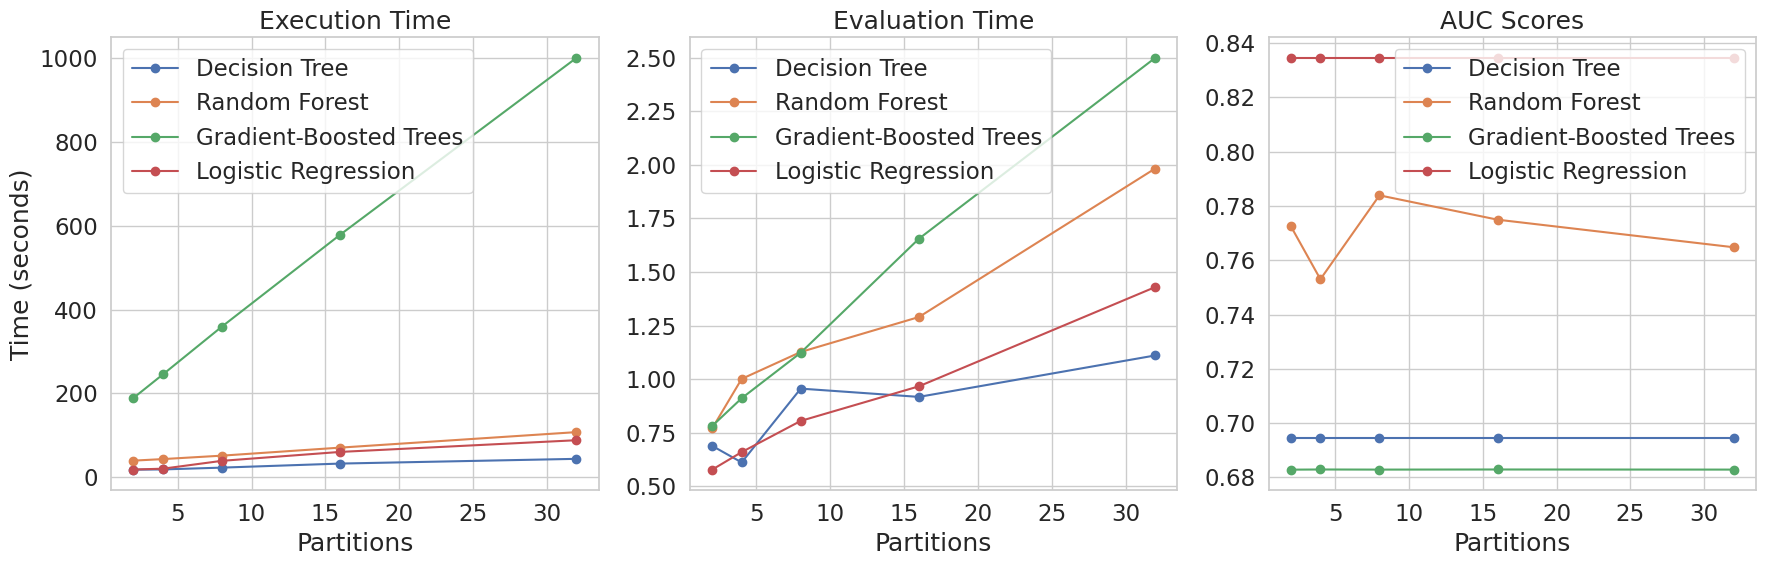

In [46]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

for model in results.keys():
    partitions = list(results[model].keys())
    exec_times = [results[model][part][0] for part in partitions]
    eval_times = [results[model][part][1] for part in partitions]
    auc_scores = [results[model][part][2] for part in partitions]

    ax1.plot(partitions, exec_times, 'o-', label=model)
    ax2.plot(partitions, eval_times, 'o-', label=model)
    ax3.plot(partitions, auc_scores, 'o-', label=model)

ax1.set_title('Execution Time')
ax1.set_xlabel('Partitions')
ax1.set_ylabel('Time (seconds)')
ax1.legend()

ax2.set_title('Evaluation Time')
ax2.set_xlabel('Partitions')
ax2.legend()

ax3.set_title('AUC Scores')
ax3.set_xlabel('Partitions')
ax3.legend()

plt.tight_layout()
plt.show()

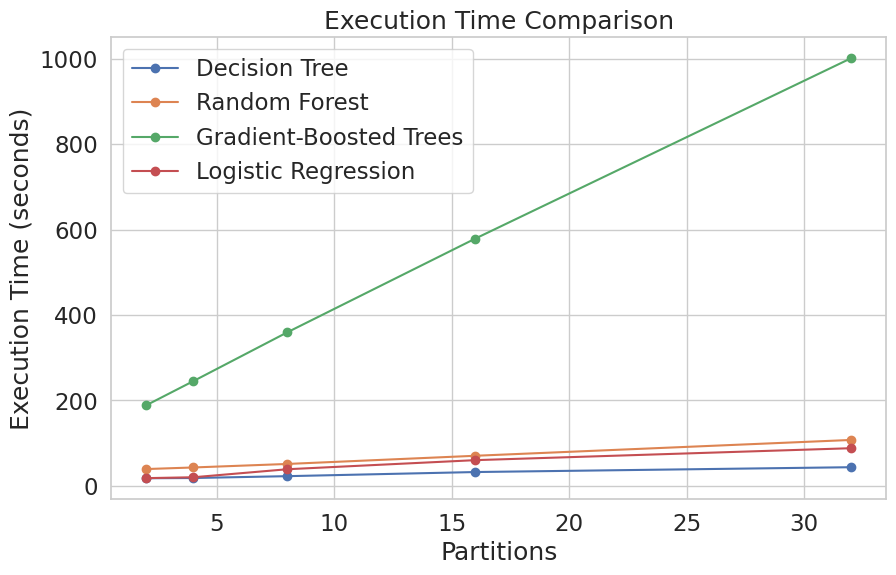

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for model in results.keys():
    partitions = list(results[model].keys())
    exec_times = [results[model][part][0] for part in partitions]
    plt.plot(partitions, exec_times, 'o-', label=model)

plt.title('Execution Time Comparison')
plt.xlabel('Partitions')
plt.ylabel('Execution Time (seconds)')
plt.legend()
plt.grid(True)
plt.show()